# Assignment 1 - Exploratory Data Analysis

In this notebook, you will find the code used to generate the MVP for the [SyntaxSprout platform](https://syntaxsprout.my.canva.site/overview). To achieve this result, we explored different datasets and different techniques.

1. `DAX dataset exploration`: we looked at the distribution and delta (external - internal) actions scores for the various companies from the DAX dataset.
2. `Word frequencies`: we then started looking at the words (boiled down to their stems) that were the most frequent across companies and between the external and internal documents. We illustrate the results with single companies but the functions can be used to generate the results for all companies.
3. `Word arithmetic`: finally, we transformed the words into vectors thanks to the pretrained [paraphrase-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2) sentence encoder. This enabled us to compare the documents:
    - 3.1 To the 17 SDGs as described on wikipedia
    - 3.2 To the [greenwashing2 dataset](https://huggingface.co/datasets/Emanuse/greenwashing_2) from Emanuse (less reliable source)
    - 3.3 Between the external and internal documents of the same company
4. `Sentiment analysis`: to link our exploration to financial performance, we used the [FinancialBERT-Yahoo-Finance-Sentiment-Analysis](https://huggingface.co/ugursa/FinancialBERT-Yahoo-Finance-Sentiment-Analysis) to generate a sentiment of the financial news for each company. We did it based on the external documents only. Finally, we compared these sentiments with the action scores to see if there was a correlation as expected.

The tokenisation and embedding of the documents we realised through this process were saved in a pickle file to be reused in the `ASS1 Modeling` notebook.

---
---

## 1. DAX dataset exploration

In [2]:
import pandas as pd
from collections import Counter
import tqdm
tqdm.tqdm.pandas()
import spacy
import string
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_pickle("DATA/esg_documents_for_dax_companies_with_scores_all.pkl")

# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_pickle("https://media.githubusercontent.com/media/JosPolfliet/vlerick-mai-nlp-2023/main/DATA/esg_documents_for_dax_companies_with_scores_all.pkl")

df

,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url,mean_action_score,n_chunks,n_estimated_actions
0,Beiersdorf AG,Sustainability Highlight Report CARE BEYOND SK...,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN,0.883412,25.0,22.0
1,Deutsche Telekom AG,Corporate Responsibility Report 2021 2 Content...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'Iso50001', 'GlobalWarming', ...",1,DTE,DeutscheTelekomAG Sustainability Report 2021,NaN,0.663768,263.0,173.0
2,Vonovia SE,VONOVIA SE SUSTAINABILITY REPORT 2021 =For a S...,sustainability_report,2021-03-31,NaN,"['Whistleblowing', 'DataSecurity', 'Vaccine', ...",1,VNA,VonoviaSE Sustainability Report 2021,NaN,0.429047,193.0,79.0
3,Merck KGaA,Sustainability Report 2021 TABLE OF CONTENTS S...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'DataMisuse', 'DrugResistance...",1,MRK,MerckKGaA Sustainability Report 2021,NaN,0.679299,210.0,142.0
4,MTU,Our ideas and concepts FOR A SUSTAINABLE FUTUR...,sustainability_report,2020-03-31,NaN,"['WorkLifeBalance', 'Corruption', 'AirQuality'...",1,MTX,MTUAeroEngines Sustainability Report 2020,NaN,0.682892,102.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11543,Zalando SE,"To reset your pass, please enter your email be...",tech,2021-07-12,pocketgamer,"['CustomerService', 'Meat', 'HumanCapital', 'T...",0,ZAL,Pocket Gamer Connects Digital # 7,https://www.pocketgamer.biz/events/1636/pocket...,0.595652,13.0,8.0
11544,Zalando SE,Lo esencial: Materias primas: correlaciones e...,business,2022-07-05,marketscreener,['WasteManagement'],0,ZAL,"Índices: ni Value ni Growth, ¡defensivos!",https://es.marketscreener.com/noticias/ultimas...,0.000032,3.0,0.0
11545,Zalando SE,A look at the evolution of the fashion industr...,thinktank,2021-05-11,cbinsights,"['CustomerService', 'Recruiting', 'Sustainable...",0,ZAL,The Future of Fashion: Technology & the Industry,https://www.cbinsights.com/research/fashion-te...,0.996982,32.0,32.0
11546,Zalando SE,"By clicking submit, you agree to share your em...",tech,2022-05-23,techfundingnews,"['ClimateTech', 'Cybersecurity', 'CorporateCul...",0,ZAL,These are the top 10 EMEA VCs of 2022 — TFN,https://techfundingnews.com/these-are-the-top-...,0.470160,6.0,2.0


### 1.1. Cleaning

The necessary packages are imported and the DAX dataset is loaded. The dataset is then cleaned by:
- Removing the rows with missing action scores or content
- Identify acceptable document length to enable tokenisation with `spacy` and keep most information

C:\Users\User\AppData\Local\Temp\ipykernel_20768\2471562946.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["size_char"] = df_1["content"].apply(lambda x: len(x))


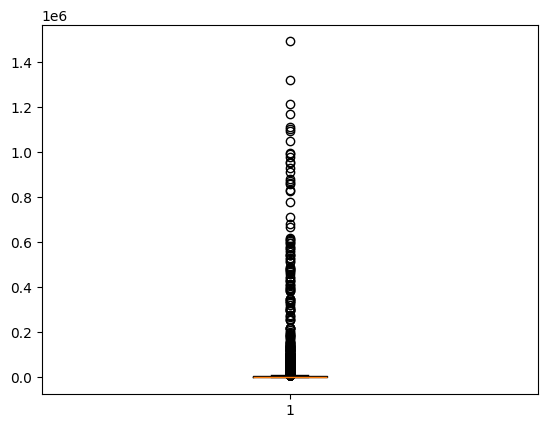

Deciles of all documents length /n >> [   67.  1412.  2138.  2687.  3232.  3865.  4619.  5569.  7177. 10323.]
Deciles of internal documents length /n >> [ 28749. 117981. 217730. 323361. 387622. 461123. 530884. 606460. 859091.
 992910.]
We will truncate 0.37% of the documents to 500k characters
It represents 42.86% of the internal documents


100%|██████████| 11531/11531 [00:00<00:00, 330358.74it/s]


In [3]:
# Focus on the rows with a score and content
df_1 = df[np.logical_and(
    np.logical_not(df['n_chunks'].isnull()),
    np.logical_not(df['content'].isnull())
)]

# Add a column with the number of characters to truncate overly long documents
df_1["size_char"] = df_1["content"].apply(lambda x: len(x))
plt.boxplot(df_1["size_char"]) # huge right tail
plt.show()

deciles = np.percentile(df_1["size_char"], np.arange(0, 100, 10))
print("Deciles of all documents length","/n >>", deciles) # 90% of documents fall under 10k characters
deciles_int = np.percentile(df_1[df_1["internal"]==1]["size_char"], np.arange(0, 100, 10))
print("Deciles of internal documents length","/n >>", deciles_int) # However internal documents are much longer
print(f"We will truncate {len(df_1[df_1['size_char'] > 500000])/len(df_1):.2%} of the documents to 500k characters")
print(f"It represents {len(df_1[np.logical_and(df_1['size_char'] > 500000, df_1['internal']==1)])/len(df_1[df_1['internal']==1]):.2%} of the internal documents")

# Truncate documents to 500k characters
df_1.loc[:,"content"] = df_1.loc[:,"content"].progress_apply(lambda x: x[:500000] if len(x) > 500000 else x)

### 1.2. Distribution of action scores

The first step is to look at the distribution of the mean action scores across all the documents for each company. If the external documents mean give us information as how the company is perceived by the public, the delta with the internal documents mean gives us insight into the gap between how the company presents itself and how it is perceived.

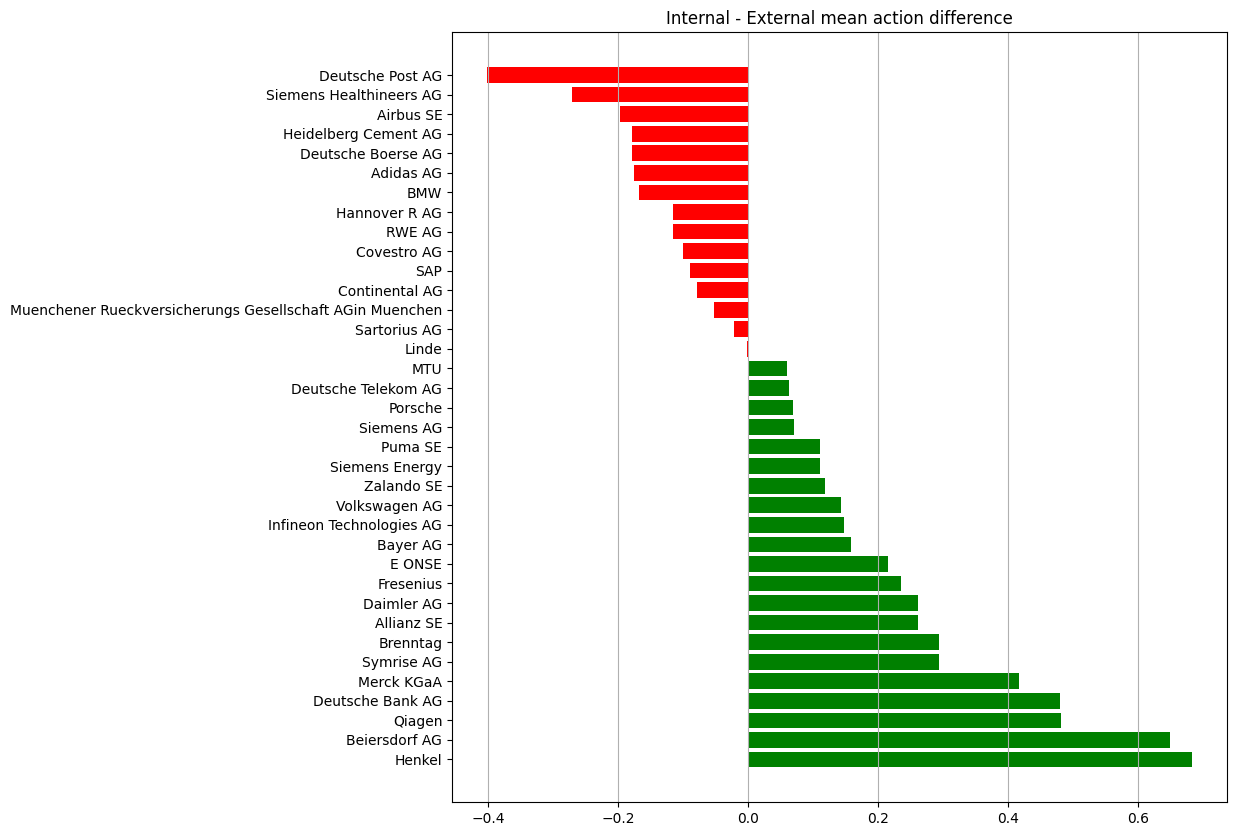

In [6]:
# Mean action score per company (min and max added for reference)
agg_table = df_1.groupby(["company","internal"]).agg({
    'mean_action_score': ['mean', 'min', 'max'], 'company': ["count"]
}).reset_index()

agg_table.columns = ["company","internal","mean_action_score_mean","mean_action_score_min","mean_action_score_max","count"]
agg_table

# Delta computation between internal and external documents
diff_table = agg_table[agg_table["internal"] == False].merge(
    agg_table[agg_table["internal"] == True],
    on="company",
    suffixes=("_external","_internal")
)

diff_table["mean_difference"] = diff_table["mean_action_score_mean_internal"] - diff_table["mean_action_score_mean_external"]
diff_table.sort_values("mean_difference", ascending=False, inplace=True)

# Visualize the difference
plt.figure(figsize=(10,10))
plt.barh(
    diff_table["company"], diff_table["mean_difference"],
    color=np.where(diff_table["mean_difference"] > 0, "green", "red"))
plt.title("Internal - External mean action difference")
plt.grid(axis="x")
plt.show()


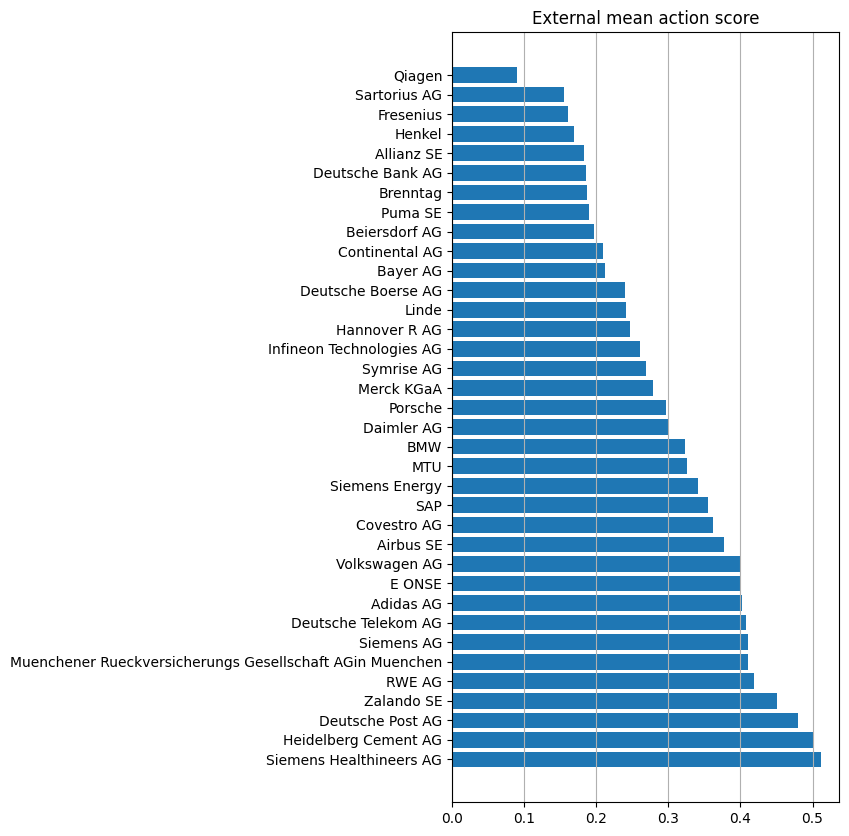

In [7]:
# Visualize the external mean action score as well (perceived action score)
diff_table.sort_values("mean_action_score_mean_external", ascending=False, inplace=True)
plt.figure(figsize=(5,10))
plt.barh(
    diff_table["company"], diff_table["mean_action_score_mean_external"])
plt.title("External mean action score")
plt.grid(axis="x")
plt.savefig("DATA/figures/external_mean_action_score.png")
plt.show()

## 2. Word frequencies

We will now start looking into the textual content information. We tokenize the documents and remove the stop words and punctuation. We then stem the words to reduce the number of unique words. We can then look at the most frequent words across external and internal documents for the various companies.

In [8]:
# !python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation
# We made sure that no text was over 500k characters so no try except needed to catch the exception
def spacy_tokenizer(sentence):
    """Transforms a sentence into a list of lemma tokens and remove stop words and punctuation.

    Parameters
    ----------
    sentence : str
        Input sentence.

    Returns
    -------
    list
        List of lemma tokens.
    """
    mytokens = nlp(sentence.lower())
    mytokens = [word for word in mytokens if not word.is_oov and not word.is_stop and not word.is_punct]
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens

c:\Users\User\Documents\VLERICK\NLP\vlerick-mai-nlp-2023\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will tokenize all of the text and store it in a pickle to be able to use it later.

In [6]:
%%time

df_test = df_1.copy()
df_test = df_test.iloc[:10,:] # small dataset to test code on CPU

def tokenize_text(data, from_column, to_column):
    """Tokenize a column of text and add the result to a new column."""
    df_test[to_column] = df_test[from_column].progress_apply(spacy_tokenizer)    

# tokenize_text(df_test, "content", "tokens")
# print("The tokenisation of the first document reduces the number of characters (words -> lemma) from",
#     len(df_test["content"][0]), "to", len(" ".join(df_test["tokens"][0]))) # Success

## Google Colab
# Tokenize all documents and save the result in a new pickle file
# tokenize_text(df_1, "content", "tokens")
# df_1.to_pickle("/content/drive/MyDrive/Masters 24/NLP/Data/esg_documents_for_dax_companies_with_scores_tokenized.pkl")

CPU times: total: 0 ns
Wall time: 4.98 ms


### 2.1. Frequency of words

We start with visualizing the words frequencies as a simple number. We compare internal with external documents from `Henkel` and clearly see that there are a lot of mentions of sustainability, employees, and packaging in the internal documents. In the external documents, we see a lot of purely market-related words. By researching this gap, we find that `Henkel` under-delivers despite high promesses:

- https://vikajewels.com/blogs/blog-by-vika/what-is-really-behind-henkels-sustainability-initiative
- https://www.lsa-conso.fr/comment-le-chat-s-est-remis-au-vert-apres-son-bad-buzz,170775 (in French, there is a recovery after bad buzz)


In [5]:
## Checkpoint to start from here and save the tokenization time

import pandas as pd
from collections import Counter
import tqdm
tqdm.tqdm.pandas()
import spacy
import string
import matplotlib.pyplot as plt
import numpy as np

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_pickle("https://media.githubusercontent.com/media/MathieuDemarets/vlerick-mai-nlp-2023/Local/DATA/esg_documents_for_dax_companies_with_scores_tokenized.pkl")
df = pd.read_pickle("DATA/esg_documents_for_dax_companies_with_scores_tokenized.pkl")

df.head()

,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url,mean_action_score,n_chunks,n_estimated_actions,size_char,tokens
0,Beiersdorf AG,Sustainability Highlight Report CARE BEYOND SK...,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN,0.883412,25.0,22.0,56786,"[sustainability, highlight, report, care, skin..."
1,Deutsche Telekom AG,Corporate Responsibility Report 2021 2 Content...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'Iso50001', 'GlobalWarming', ...",1,DTE,DeutscheTelekomAG Sustainability Report 2021,NaN,0.663768,263.0,173.0,619607,"[corporate, responsibility, report, 2021, 2, c..."
2,Vonovia SE,VONOVIA SE SUSTAINABILITY REPORT 2021 =For a S...,sustainability_report,2021-03-31,NaN,"['Whistleblowing', 'DataSecurity', 'Vaccine', ...",1,VNA,VonoviaSE Sustainability Report 2021,NaN,0.429047,193.0,79.0,444517,"[se, sustainability, report, 2021, sustainable..."
3,Merck KGaA,Sustainability Report 2021 TABLE OF CONTENTS S...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'DataMisuse', 'DrugResistance...",1,MRK,MerckKGaA Sustainability Report 2021,NaN,0.679299,210.0,142.0,543061,"[sustainability, report, 2021, table, content,..."
4,MTU,Our ideas and concepts FOR A SUSTAINABLE FUTUR...,sustainability_report,2020-03-31,NaN,"['WorkLifeBalance', 'Corruption', 'AirQuality'...",1,MTX,MTUAeroEngines Sustainability Report 2020,NaN,0.682892,102.0,68.0,256566,"[idea, concept, sustainable, future, idea, con..."


In [9]:
def countWordFrequencies(example, counter):
    tokens = spacy_tokenizer(example)
    counter.update(tokens)

def frequency_df(df, tokens = True):
    """Count the word frequencies in a dataframe.

    Parameters
    ----------
    df : DataFrame
        Initial dataframe with text in 'content' or tokens in 'tokens' column.
    tokens : bool, optional
        If we should use the token columns. If not, we first tokenize, by default True

    Returns
    -------
    DataFrame
        Word frequencies sorted by count.
    """
    counter = Counter()
    if tokens:
        df['tokens'].progress_apply(lambda x: counter.update(x))
    else:
        df['content'].progress_apply(lambda x: countWordFrequencies(x, counter))
    freq_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
    freq_df = freq_df.rename(columns={'index':'word', 0:'count'})
    freq_df = freq_df.sort_values(by='count', ascending=False)
    return freq_df

def compare_frequencies(df, company, save=False, top=20, directory='DATA/figures/', tokens=True):
    """Plot the word frequencies for internal and external documents.

    Parameters
    ----------
    df : DataFrame
        Initial dataframe with text in 'content' or tokens in 'tokens' column.
    company : str
        Company to filter for.
    save : bool, optional
        Save the plot, by default False
    top : int, optional
        Numbers of most frequent words to keep, by default 20
    directory : str, optional
        Directory to save the plot, by default 'DATA/figures/'
    tokens : bool, optional
        If we should use the token columns. If not, we first tokenize, by default True

    Returns
    -------
    None
    """
    df_1 = df[df['company'] == company]
    count_int = frequency_df(df_1[df_1['internal'] == 1], tokens=tokens)
    count_ext = frequency_df(df_1[df_1['internal'] == 0], tokens=tokens)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
    ax1.barh(count_int['word'][:top][::-1], count_int['count'][:top][::-1])
    ax1.set_title('Internal ({:,.0f} tokens)'.format(count_int['count'].sum()))
    ax2.barh(count_ext['word'][:top][::-1], count_ext['count'][:top][::-1])
    ax2.set_title('External ({:,.0f} tokens)'.format(count_ext['count'].sum()))
    plt.suptitle(company)
    plt.tight_layout()
    if save:
        plt.savefig('{}{}_word_frequencies.png'.format(directory,company))
    plt.show()

100%|██████████| 66/66 [00:00<00:00, 10946.42it/s]

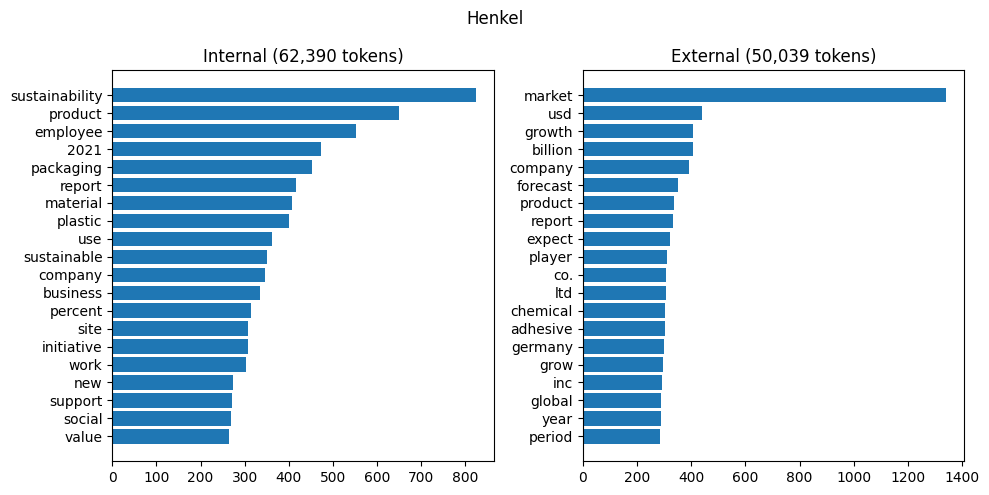

CPU times: total: 984 ms
Wall time: 1.04 s


In [9]:
%%time
compare_frequencies(df, 'Henkel', save=True, tokens=True) # The process takes around 1s per company on CPU now that we have tokenized the documents

### 2.2. Wordcloud

Then, we visualize the most common words per company in a wordcloud. We make the difference between the words that are in the company's report and the words that are in the external sources. We can already see some discrepancies between the two. If we look at the `Deutsche Bank` which was one of the most likely to greenwash according to the numerical action score, we see the words `trump`, `trump organization`, and `prosecutor` popping up in the external sources. This is probably due to the fact that the bank was [financially fooled by the Trump organization](https://www.forbes.com/sites/danalexander/2023/10/16/how-trump-fooled-deutsche-bank/). This is a good example of how the external sources can be used to detect unseen information.

In [10]:
# inspired from https://medium.com/mlearning-ai/wordclouds-with-python-c287887acc8b

import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def add_wordcloud(text, company, ax, internal = True, random_state=42, tokens = True):
    """Add a wordcloud to an axis.
    """
    if tokens:
        text = text.translate({ord(i): None for i in '[",]'})
    else:
        text = " ".join(spacy_tokenizer(text))
    wc = WordCloud(background_color='white', colormap = 'magma', max_words=100,
        stopwords = spacy_tokenizer(company), height = 500, width = 800, random_state=random_state
        ).generate(text)
    ax.axis("off")
    ax.imshow(wc)
    ax.set_title(
        f'{company} {"internal" if internal else "external"}',
        color='black',fontsize=20,loc='left')

def compare_wordclouds(data, company, save=False, random_state=42, directory='DATA/figures/', tokens = True):
    """Plot the wordclouds for internal and external documents of a given company.
    """
    df2 = data[data['company'] == company]
    df2int = df2[df2['internal'] == 1]
    df2ext = df2[df2['internal'] == 0]

    if tokens:
        text_int = " ".join([" ".join(list_tok) for list_tok in df2int['tokens']])
        text_ext = " ".join([" ".join(list_tok) for list_tok in df2ext['tokens']])

    else:
        text_int = " ".join(df2int['content'].tolist())
        text_ext = " ".join(df2ext['content'].tolist())

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
    try:
        add_wordcloud(text_int, company, ax1, random_state=random_state, tokens = tokens)
    except:
        add_wordcloud(text_int[:900000], company, ax1, random_state=random_state, tokens = tokens)
    try:
        add_wordcloud(text_ext, company, ax2, internal = False, random_state=random_state, tokens = tokens)
    except:
        add_wordcloud(text_ext[:900000], company, ax2, internal = False, random_state=random_state, tokens = tokens)
    plt.tight_layout()
    if save:
        plt.savefig(f'{directory}wordcloud_{company}.png')
    plt.show()

# compare_wordclouds(df_1, 'Deutsche Bank AG', save=True, tokens=False)
# https://www.forbes.com/sites/danalexander/2023/10/16/how-trump-fooled-deutsche-bank/
# >> Trump issue

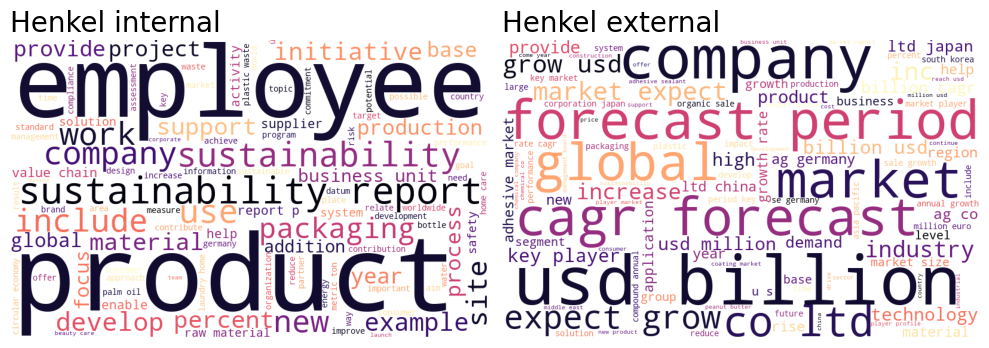

CPU times: total: 2.3 s
Wall time: 2.43 s


In [11]:
%%time
compare_wordclouds(df, 'Henkel', save=True, tokens=True)
# The process is much faster now that we have tokenized the documents (1m to 2.5s per company on CPU)

### 2.3. ESG topics addressed

We can take the same approach to look at the differences in topics addressed. It looks like the variety of topics is much higher in the internal documents than in the external ones.

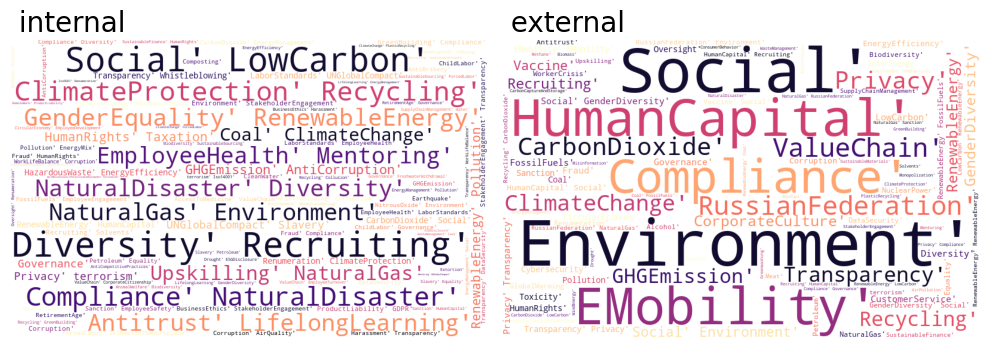

In [12]:
df2 = df_1
df2int = df2[df2['internal'] == 1]
df2ext = df2[df2['internal'] == 0]

text_int = " ".join(df2int['esg_topics'].tolist())
text_ext = " ".join(df2ext['esg_topics'].tolist())

company=""
random_state=42
save=True
directory='DATA/figures/'

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
try:
    add_wordcloud(text_int, company, ax1, random_state=random_state)
except:
    add_wordcloud(text_int[:900000], company, ax1, random_state=random_state)
try:
    add_wordcloud(text_ext, company, ax2, internal = False, random_state=random_state)
except:
    add_wordcloud(text_ext[:900000], company, ax2, internal = False, random_state=random_state)
plt.tight_layout()
if save:
    plt.savefig(f'{directory}wordcloud_esg_topics.png')
plt.show()

In [13]:
## Fancy word cloud with DB for the MVP

# DB_mask = np.array(Image.open("DATA/DB_logo.jpg"))

# wc = WordCloud(
#     background_color = 'white', mask = DB_mask, contour_width = 2, stopwords = spacy_tokenizer('Deutsche Bank AG'),
#     contour_color = 'white', colormap = 'Greys', width = 800, height = 500).generate(
#         " ".join(spacy_tokenizer(" ".join(df_1[np.logical_and(
#             df_1['company'] == 'Deutsche Bank AG',
#             df_1['internal'] == 0
#     )]['content'].to_list())[:900000])))
# plt.axis("off")
# plt.title('Deutsche Bank AG external', color='black',fontsize=10,loc='center')
# plt.imshow(wc)
# plt.savefig('DATA/figures/wordcloud_beautiful_external.png')
# plt.show()

## 3. Word arithmetic

There is only so much we can learn and especially interpret from the frequencies of words. We can use word embeddings to go beyond that. In fact, we want to see how close documents are to each other in the embedding space. This will enable us to see for which companies the internal and external documents are far appart which could a good indicator of greenwashing.

To go further, we will also use two additional datasets:
- SDG goals description from wikipedia
- Greenwashing2 dataset found on huggingface

The goal of our analysis is to know for which companies the internal and external documents are the most similar, to see what internal reports are the closest to the text identified as greenwashing, and to see if and which SDG goals are the closest to the content of the documents.

### 3.1. Document embeddings

We will embed the tokens we had defined earlier using the pretrained [paraphrase-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2) sentence encoder. We will then save the embeddings in a pickle file to be able to use them later.

In [15]:
%%time

from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model.max_seq_length = 512 # Increase the max length of the input, default is 128

def join_tokens(data, from_tokens, to_joined):
    """Join a column of tokens and add the result to a new column."""
    data[to_joined] = data[from_tokens].progress_apply(lambda x: " ".join(x))

def content_embedding(data, from_column, to_column):
    """Compute the embedding of a column of text and add the result to a new column."""
    embed = lambda x: model.encode(x, convert_to_tensor=False)
    data[to_column] = data[from_column].progress_apply(embed)

# test = df.iloc[:10,:].copy()
# join_tokens(test, "tokens", "joined_tokens")
# test["joined_tokens"] = test["joined_tokens"].str.replace(r"\d+", "") # Remove numbers
# content_embedding(test, "joined_tokens", "embedding")
# del test["joined_tokens"]
# test # Success

# # Google Colab
# join_tokens(df, "tokens", "joined_tokens")
# df["joined_tokens"] = df["joined_tokens"].str.replace(r"\d+", "") # Remove numbers
# content_embedding(df, "joined_tokens", "embedding")
# del df["joined_tokens"]
# df.to_pickle("/content/drive/MyDrive/Masters 24/NLP/Data/esg_documents_for_dax_companies_score_tok_emb.pkl")

CPU times: total: 3.92 s
Wall time: 6.74 s


### 3.2. Internal and external documents proximity

Similarly to the visual inspection we did at a word level, we can now look at the cosine similarity between the internal and external documents per company. We see that the internal and external documents are overall quite close. This might be due to standardization of the ESG communication. The agreement between the internal and external documents is significantly lower for `Adidas` and it might be interesting to look into the reasons for that.

In [16]:
import pandas as pd
from collections import Counter
import tqdm
tqdm.tqdm.pandas()
import matplotlib.pyplot as plt
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_pickle("https://media.githubusercontent.com/media/MathieuDemarets/vlerick-mai-nlp-2023/Local/DATA/esg_documents_for_dax_companies_score_tok_emb.pkl")
df = pd.read_pickle("DATA/esg_documents_for_dax_companies_score_tok_emb.pkl")

df.head()

,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url,mean_action_score,n_chunks,n_estimated_actions,size_char,tokens,embedding
0,Beiersdorf AG,Sustainability Highlight Report CARE BEYOND SK...,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN,0.883412,25.0,22.0,56786,"[sustainability, highlight, report, care, skin...","[-0.30426386, 0.5005032, 0.44396603, 0.0309295..."
1,Deutsche Telekom AG,Corporate Responsibility Report 2021 2 Content...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'Iso50001', 'GlobalWarming', ...",1,DTE,DeutscheTelekomAG Sustainability Report 2021,NaN,0.663768,263.0,173.0,619607,"[corporate, responsibility, report, 2021, 2, c...","[-0.355663, 0.29826087, 0.4589993, -0.21578589..."
2,Vonovia SE,VONOVIA SE SUSTAINABILITY REPORT 2021 =For a S...,sustainability_report,2021-03-31,NaN,"['Whistleblowing', 'DataSecurity', 'Vaccine', ...",1,VNA,VonoviaSE Sustainability Report 2021,NaN,0.429047,193.0,79.0,444517,"[se, sustainability, report, 2021, sustainable...","[-0.16401269, 0.27424163, 0.2612646, -0.127146..."
3,Merck KGaA,Sustainability Report 2021 TABLE OF CONTENTS S...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'DataMisuse', 'DrugResistance...",1,MRK,MerckKGaA Sustainability Report 2021,NaN,0.679299,210.0,142.0,543061,"[sustainability, report, 2021, table, content,...","[-0.17004943, 0.053052265, 0.28615195, -0.2306..."
4,MTU,Our ideas and concepts FOR A SUSTAINABLE FUTUR...,sustainability_report,2020-03-31,NaN,"['WorkLifeBalance', 'Corruption', 'AirQuality'...",1,MTX,MTUAeroEngines Sustainability Report 2020,NaN,0.682892,102.0,68.0,256566,"[idea, concept, sustainable, future, idea, con...","[-0.22982949, 0.39467514, 0.258867, -0.1323035..."


In [17]:
def array_to_tensor(data, column):
    """Convert a column of numpy array to a column of torch tensor.

    Parameters
    ----------
    data : DataFrame
        Initial dataframe.
    column : str
        Column to convert.

    Returns
    -------
    torch.Tensor
        Output tensor.
    """
    to_torch = lambda x: torch.from_numpy(x)
    data.loc[:,column] = data.loc[:,column].progress_apply(to_torch)


def mean_doc_embedding(embedding):
    """Compute the mean embedding of a list of embeddings.

    Parameters
    ----------
    embedding : list of torch.Tensor
        List of embeddings.

    Returns
    -------
    torch.Tensor
        Mean embedding.
    """
    return torch.stack(tuple([ # Stack the mean for each position of the embedding
        torch.mean( # Compute the mean for each position of the embedding
            torch.stack(tuple([embed[i] for embed in embedding])) # For each document
        ) for i in range(embedding.iloc[0].shape[0])])) # For each position of the embedding

# mEMB1 = mean_doc_embedding(embedding=test["embedding"][:5])
# mEMB2 = mean_doc_embedding(embedding=test["embedding"][5:])

# print("COSINE distance between the two parts is {:.2%}".format(float(util.cos_sim(mEMB1, mEMB2)))) #Test success


In [18]:
# Compute the mean embedding for each document and the cosine similarity between internal and external documents

array_to_tensor(df, "embedding")
company_int_ext_sim = {}
for company in diff_table.company.unique(): # For each company that has both internal and external documents
    df2 = df[df['company'] == company]
    company_int_ext_sim[company] = float(util.cos_sim(
        mean_doc_embedding(embedding=df2[df2['internal'] == 1]['embedding']),
        mean_doc_embedding(embedding=df2[df2['internal'] == 0]['embedding'])
    ))


100%|██████████| 11531/11531 [00:00<00:00, 136025.04it/s]

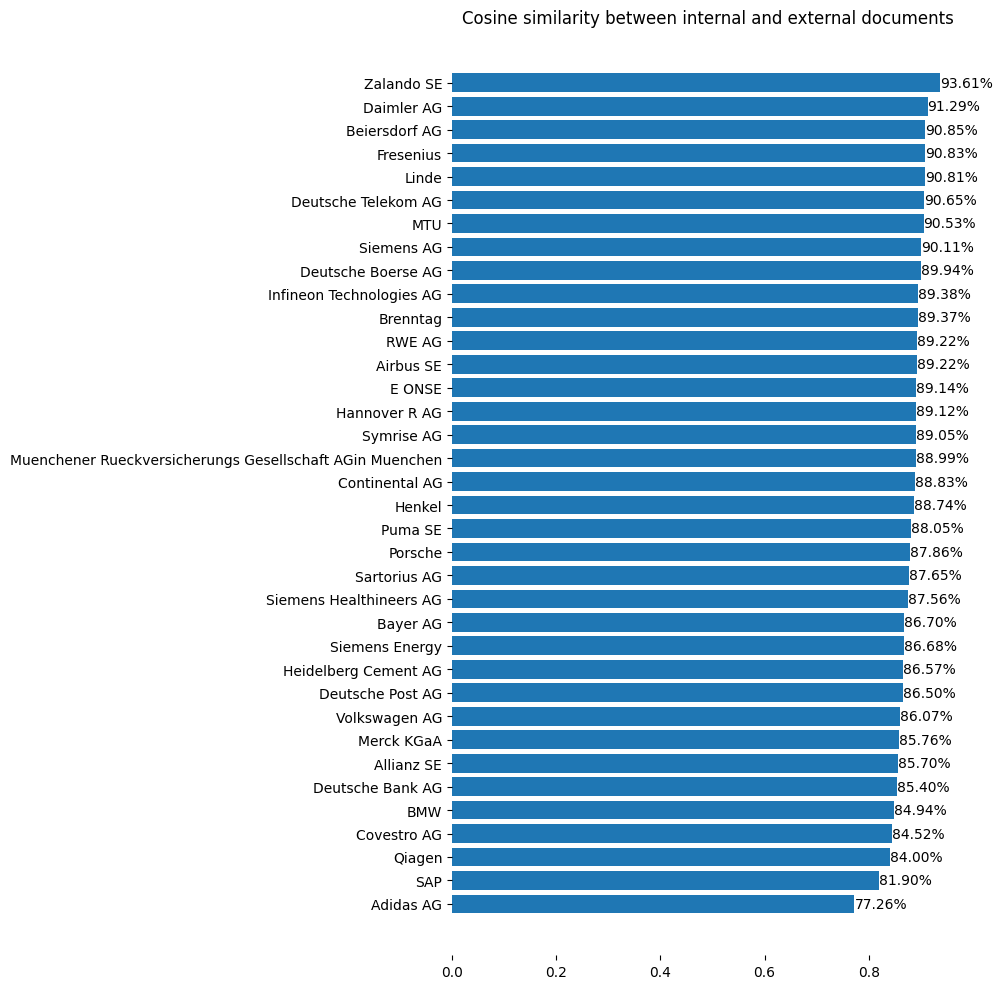

In [19]:
company_int_ext_sim = pd.DataFrame.from_dict(company_int_ext_sim, orient='index').reset_index()
company_int_ext_sim.rename(columns={'index':'company', 0:'cosine_similarity'}, inplace=True)
company_int_ext_sim.sort_values(by='cosine_similarity', ascending=True, inplace=True)
plt.figure(figsize=(10,10))
plt.barh(company_int_ext_sim['company'], company_int_ext_sim['cosine_similarity'])
for i, v in enumerate(company_int_ext_sim['cosine_similarity']):
    plt.text(v, i, "{:.2%}".format(v), color='black', va='center')
plt.title('Cosine similarity between internal and external documents')
plt.box(False)
plt.tight_layout()
plt.savefig('DATA/figures/cosine_similarity.png')
plt.show()

### 3.3. Greenwashing2 dataset

We can now look at the proximity between the internal documents and the greenwashing2 dataset. We see that some companies such as Bayer seem closer to the content of the greenwashing2 dataset than others. However, we lack information to know if greenwashing2 is a reliable source of information and we should note that the similarity is not very high.

In [20]:
# Load the dataset
from datasets import load_dataset
dataset = load_dataset("Emanuse/greenwashing_2")

# Embed the dataset
embedding_gw = model.encode(" ".join(dataset['train']['text']), convert_to_tensor=True)

In [22]:
# Compute the cosine similarity between the mean internal document embedding and the greenwashing dataset embedding
internal = df[df['internal'] == 1]
sim_gw_int = {}
for company in diff_table.company.unique():
    df2 = internal[internal['company'] == company]
    sim_gw_int[company] = float(util.cos_sim(
        mean_doc_embedding(embedding=df2['embedding']),
        embedding_gw
    ))

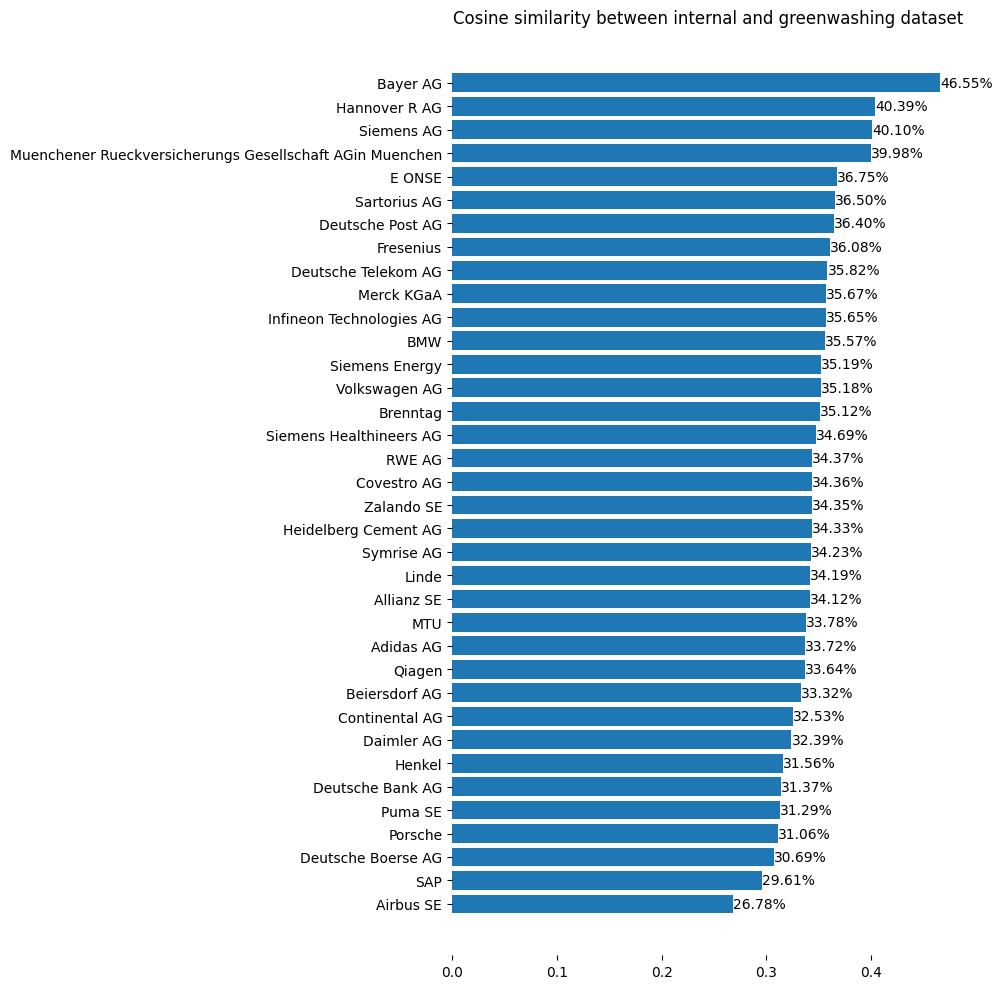

In [23]:
# Visualize the results
sim_gw_int = pd.DataFrame.from_dict(sim_gw_int, orient='index').reset_index()
sim_gw_int.rename(columns={'index':'company', 0:'cosine_similarity'}, inplace=True)
sim_gw_int.sort_values(by='cosine_similarity', ascending=True, inplace=True)
plt.figure(figsize=(10,10))
plt.barh(sim_gw_int['company'], sim_gw_int['cosine_similarity'])
for i, v in enumerate(sim_gw_int['cosine_similarity']):
    plt.text(v, i, "{:.2%}".format(v), color='black', va='center')
plt.title('Cosine similarity between internal and greenwashing dataset')
plt.box(False)
plt.tight_layout()
plt.savefig('DATA/figures/cosine_similarity_gw_int.png')
plt.show()

### 3.4. SDG goals

Finally, we can look at the proximity between the internal documents and the SDG goals. Their description has been copied from wikipedia, parsed and tokenized before transforming them into embeddings. We see that the trends in the SDG goals are quite similar across companies:
- High performance on SDG 4 (Quality education), SDG 8 (Decent work and economic growth), and SDG 12 (Responsible consumption and production).
- Low performance on SDG 14 (Life below water), SDG 15 (Life on land), and SDG 16 (Peace, justice and strong institutions).

We then vizualised these similarities into radar plot to compare the companies on 17 dimensions easily. We benchmarked the 10 companies with highest mean similarity to SDGs as well as the companies highest and lowest mean similarity.

In [24]:
# Open, parse, tokenize
with open("DATA/DSGS.txt") as doc:
    sdgs = doc.read()

SDGs = sdgs.split(">>")
del SDGs[0]
SDG_df = pd.DataFrame({
    "SDG": [sdg.split("[edit]")[0] for sdg in SDGs],
    "content": [" ".join(spacy_tokenizer(content)) for content in SDGs]
})


In [25]:
# Embed the SDGs
sdgs_embeddings = model.encode(SDG_df["content"].to_list(), convert_to_tensor=True)

In [26]:
# Embed all documents for each company
emb_companies = {"name":[], "embedding":[]}
for company in diff_table.company.unique():
    emb_companies['name'].append(company)
    emb_companies['embedding'].append(mean_doc_embedding(df[df['company']==company]["embedding"]))
    print(">",company, "embedded")

> Henkel embedded
> Beiersdorf AG embedded
> Qiagen embedded
> Deutsche Bank AG embedded
> Merck KGaA embedded
> Symrise AG embedded
> Brenntag embedded
> Allianz SE embedded
> Daimler AG embedded
> Fresenius embedded
> E ONSE embedded
> Bayer AG embedded
> Infineon Technologies AG embedded
> Volkswagen AG embedded
> Zalando SE embedded
> Siemens Energy embedded
> Puma SE embedded
> Siemens AG embedded
> Porsche embedded
> Deutsche Telekom AG embedded
> MTU embedded
> Linde embedded
> Sartorius AG embedded
> Muenchener Rueckversicherungs Gesellschaft AGin Muenchen embedded
> Continental AG embedded
> SAP embedded
> Covestro AG embedded
> RWE AG embedded
> Hannover R AG embedded
> BMW embedded
> Adidas AG embedded
> Deutsche Boerse AG embedded
> Heidelberg Cement AG embedded
> Airbus SE embedded
> Siemens Healthineers AG embedded
> Deutsche Post AG embedded


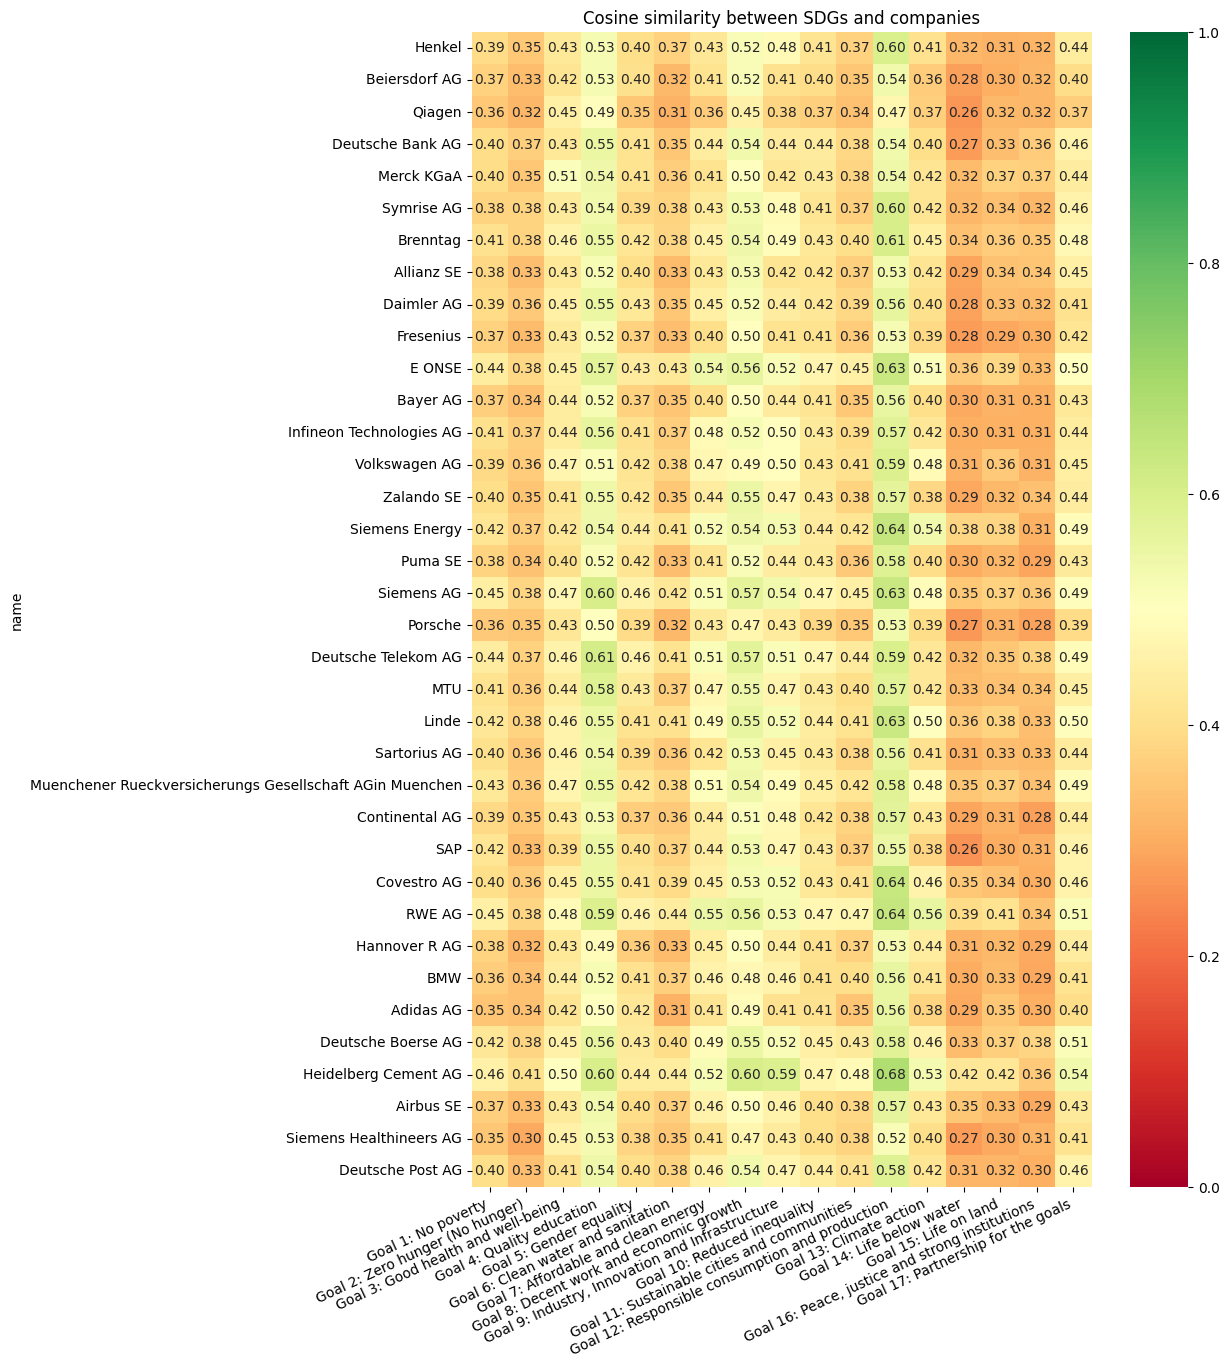

In [27]:
# Vizualise the heatmap
import seaborn as sns

emb_companies = pd.DataFrame(emb_companies)
emb_companies['embedding'].to_list()[0].shape
util.cos_sim(sdgs_embeddings[0], emb_companies['embedding'][0])

heatmap_cp_sdg = pd.DataFrame()
heatmap_cp_sdg.index = emb_companies['name']
for s in range(sdgs_embeddings.shape[0]):
    heatmap_cp_sdg[SDG_df["SDG"][s]] = [float(util.cos_sim(
        sdgs_embeddings[s], emb_companies['embedding'][c]
    )) for c in range(emb_companies['embedding'].shape[0])]
plt.figure(figsize=(10,15))
sns.heatmap(heatmap_cp_sdg, cmap="RdYlGn", vmin=0, vmax=1, annot=True, fmt=".2f")
plt.xticks(rotation=25, ha="right")
plt.title("Cosine similarity between SDGs and companies")
plt.savefig('DATA/figures/sdg_similarity_heatmap.png')
plt.show()


In [28]:
import math
import plotly.graph_objects as go

# Prepare the data for the radar plots
radar_df = heatmap_cp_sdg.copy()
radar_df["Global_Mean"] = heatmap_cp_sdg.mean(axis=1)
radar_df.sort_values("Global_Mean", ascending=False, inplace=True)
radar_df_best = radar_df.iloc[:10,:]
radar_extreme = pd.concat([radar_df.iloc[0,:], radar_df.iloc[-1,:]], axis=1).T
best_boundary = math.ceil(10*radar_df_best.max(axis=1).max())/10

In [61]:
# Make the radar plot for the 10 best companies
categories = SDG_df["SDG"].to_list()

fig = go.Figure()

for company in radar_df_best.index:
    fig.add_trace(go.Scatterpolar(
        r=radar_df_best.loc[company,categories].apply(lambda x: round(x,2)),
        theta=categories,
        # fill='toself',
        name=company
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,best_boundary]
    )),
  showlegend=True
)

fig.show()


In [31]:
# Make the radar plot for the 2 extreme companies
categories = SDG_df["SDG"].to_list()

fig = go.Figure()

for company in radar_extreme.index:
    fig.add_trace(go.Scatterpolar(
        r=radar_extreme.loc[company,categories].apply(lambda x: round(x,2)),
        theta=categories,
        # fill='toself',
        name=company
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,best_boundary]
    )),
  showlegend=True
)

fig.show()


## 4. Sentiment analysis

The financial sentiment analysis enables us to link our exploration to financial performance. Because we see a sizeable correlation between the action scores and the sentiment, we know that there is value in being able to predict the action score for new documents. Based on this last step, we created different models to predict the action score based on the content of the documents (Bag of Words, TF-IDF, and Doc2Vec embeddings used to train classification algorithms). The results are presented in the `ASS1 Modeling` notebook.

In [32]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

### 4.1. Testing and predictions

In [44]:
%%time 
# pipe("The company was is growing") # Success
# pipe("Stock price is going down") # Success
# pipe("The company is going bankrupt") # Success
# pipe("The firm is scaling fast and well") # Success

# external = pd.DataFrame(df[df['internal'] == 0])
# external.reset_index(inplace=True)
# external["tokens"] = external["tokens"].apply(lambda x: " ".join(x))
# external["tokens"] = external["tokens"].str.replace(r"\d+", "") # Remove numbers
# external["tokens"] = external["tokens"].apply(lambda x: x[:512] if len(x) > 512 else x) # Truncate to 512 characters

# external["label"] = np.nan
# external["score"] = np.nan
# external.loc[:,["label","score"]] = pd.DataFrame(pipe(external["tokens"].to_list()))

CPU times: total: 1h 25min
Wall time: 22min 21s


### 4.2. Vizualisation of sentiments

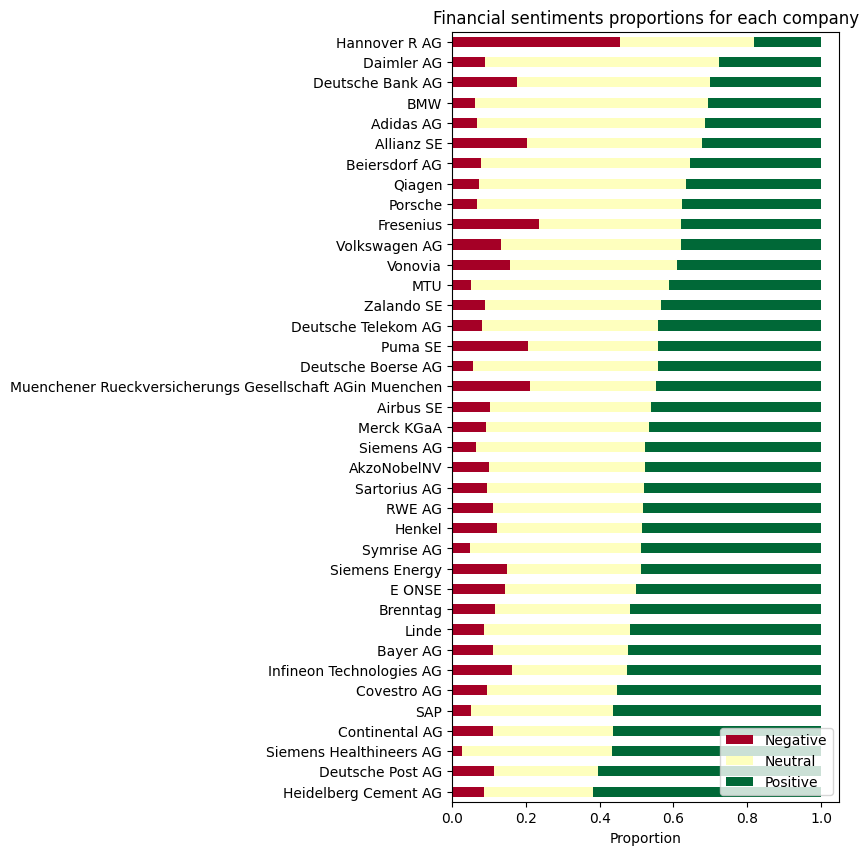

In [85]:
# external = pd.read_csv("DATA/external_sentiment.csv")
external["label"].value_counts(normalize=True)
sentiments = pd.DataFrame(external.groupby("company")["label"].value_counts(normalize=True).unstack()).sort_values("positive", ascending=False)
# external.to_csv("DATA/external_sentiment.csv")

# Plot the bar plot
sentiments.plot(kind="barh", stacked=True, figsize=(5,10), colormap="RdYlGn")
plt.title("Financial sentiments proportions for each company")
plt.xlabel("Proportion")
plt.ylabel("")
plt.legend(["Negative", "Neutral", "Positive"])
plt.savefig('DATA/figures/financial_sentiments.png')
plt.show()

### 4.3. Correlation with action scores

In [82]:
diff_table_m = diff_table.loc[:,["company","mean_action_score_mean_external"]].merge(sentiments, on="company")
diff_table_m.set_index("company", inplace=True)
corr = diff_table_m.corr()['mean_action_score_mean_external']
corr = corr.drop("mean_action_score_mean_external")
corr

negative   -0.253594
neutral    -0.145135
positive    0.334995
Name: mean_action_score_mean_external, dtype: float64

Thank you for reading this notebook. I hope you enjoyed it and that it gave you some insights into the potential of NLP for ESG analysis.

---
Mathieu Demarets (mathieu.demarets@edu.vlerick.com)